<a href="https://colab.research.google.com/github/neohack22/ebw3nt/blob/main/Correction_lab_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est de mettre en place un classificateur simple pour l'analyse de texte et de sentiments. La tâche consiste en la classification binaire des critiques de films. Le jeu de données utilisé fait partie du jeu de données *imdb*. Vous pouvez trouver le jeu de données original sur le site web d'*[imdb](https://www.imdb.com/interfaces/)* ou une version sur le site web de [Kaggle](https://www.kaggle.com/utathya/imdb-review-dataset). Pour ce TP, nous utiliserons une version prétraitée.

Déroulement :

- Charger, nettoyer et configurer les données (étape cruciale en pratique, mais nous l'ignorons pour ce TP).

- Préparer les données pour les modèles PyTorch.

- Définir votre propre modèle.

- Expérimentations.

# Les données

Les jeux de données sont disponibles dans le dépôt cloud. Il y a deux fichiers : un pour les critiques positives (imdb.pos) et un pour les critiques négatives (imdb.neg). Chaque classe contient 300 000 exemples.

Voici deux fonctions pour charger et nettoyer les données.

In [ ]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

th.manual_seed(1) # set the seed

### Imports essentiels

* **re** : traitement de texte (regex)
* **numpy** : opérations numériques rapides
* **torch** : création et entraînement de modèles
* **torch.autograd** : calcul automatique des gradients
* **torch.nn / torch.nn.functional** : couches et fonctions de réseaux
* **random / math** : fonctions utilitaires
* **pickle / gzip** : chargement & sauvegarde de données

Ces imports préparent tout le pipeline :
> **manipuler les données → définir un modèle → l’entraîner → sauvegarder.**

---

### Fixer le seed

```python
th.manual_seed(1)
```

 : garantir la reproductibilité

* mêmes poids initiaux
* mêmes résultats d’un run à l’autre
* plus facile à déboguer
* indispensable pour les projets collaboratifs

# 🔹 TensorFlow vs PyTorch : différences conceptuelles

### 1) **Paradigme principal**

| Aspect      | TensorFlow                                                                             | PyTorch                                                                             |
| ----------- | -------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| Type        | Graphes statiques (TF1.x) / Graphes dynamiques (TF2.x avec Eager Execution)            | Graphes dynamiques (Define-by-Run)                                                  |
| Implication | Le graphe est défini **avant** l’exécution → optimisation possible mais moins intuitif | Le graphe se construit **au moment de l’exécution** → plus intuitif, facile à debug |

* TensorFlow classique : “on planifie l’itinéraire avant de partir”
* PyTorch : “on construit la route au fur et à mesure qu’on avance”

---

### 2) **Débogage et lisibilité**

* **PyTorch** : simple, syntaxe Python native → les erreurs sont immédiates, facile à utiliser pour expérimenter.
* **TensorFlow** : TF1.x nécessitait des sessions et placeholders → plus compliqué à debug, TF2.x améliore beaucoup avec `Eager Execution`.

---

### 3) **API et flexibilité**

* **PyTorch** : API plus “Pythonique”, très proche du code scientifique classique (numpy-like).
* **TensorFlow** : API plus rigide au départ, mais très modulable via Keras et TF Hub pour déployer facilement en production.

---

### 4) **Déploiement et production**

* **TensorFlow** : meilleur pour la production et les modèles mobiles / web (TensorFlow Lite, TensorFlow.js).
* **PyTorch** : historquement plus orienté recherche, mais avec TorchScript et PyTorch Lightning, le déploiement devient facile.

---

### 5) **Communauté et adoption**

* **PyTorch** : très populaire dans la recherche académique et expérimentations rapides.
* **TensorFlow** : très utilisé dans l’industrie et les solutions commerciales, notamment pour l’IA intégrée et les produits Google.

> PyTorch = intuitif, flexible, idéal pour expérimenter et prototyper.
> TensorFlow = industrialisable, modulable, idéal pour déployer à grande échelle.

# Chargement des données

Charger les données :

In [ ]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# You can download the file with the following line:
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

--2022-04-06 11:30:46--  https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA
Resolving drive.google.com (drive.google.com)... 172.217.18.206, 2a00:1450:4007:812::200e
Connecting to drive.google.com (drive.google.com)|172.217.18.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n2hk1hevtcvg0o0qrmu5u6kngpg8htco/1649237400000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download [following]
--2022-04-06 11:30:50--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n2hk1hevtcvg0o0qrmu5u6kngpg8htco/1649237400000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 216.58.213.129, 2a00:1450:4007:811::2001
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleus

**On télécharge automatiquement le fichier de données et on le sauvegarde sous le nom `imdb.pck.gz`.**

* Le fichier s’appelle : `imdb.pck.gz`
* `.gz` → signifie que le fichier est **compressé** (comme un ZIP).
* `.pck` → signifie qu’il contient des **données Python sérialisées** (stockées pour être réouvertes plus tard).

---

```python
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz
```

est une commande exécutée **depuis Python**, mais c’est en réalité une instruction système :

* `wget` → un outil pour télécharger un fichier depuis internet
* l’URL → pointe vers un fichier stocké sur Google Drive
* `-O imdb.pck.gz` → on choisit le **nom du fichier** que l’on veut obtenir localement

Ouvrez les données avec Python et vous obtiendrez trois objets :

- *texts* : une liste de tenseurs, chaque tenseur représentant une séquence de mots à classifier.

- *labels* : la classe (positive ou négative) du texte correspondant.

- *lexicon* : un dictionnaire associant les entiers aux mots.

In [ ]:
fp = gzip.open(filename,'rb')
texts , labels, lexicon  = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

<class 'list'> <class 'torch.Tensor'> <class 'dict'>
tensor([ 36,  25, 381,  10,  58,  21,  83])
nb examples :  30000
Vocab size:  5002


Ce code lit un fichier compressé contenant des données Python préparées pour du traitement de texte ou du machine learning. On récupère les textes, leurs étiquettes, et le lexique pour pouvoir ensuite les utiliser dans un modèle :

1. **Ouverture du fichier compressé**

* `gzip.open` ouvre un fichier `.gz` en mode lecture binaire (`'rb'`).
* Le fichier contient des données Python sauvegardées précédemment avec `pickle`.

2. **Chargement des objets Python**

* `pickle.load(fp)` **décompresse et restaure** les objets Python contenus dans le fichier.
* Ici, on récupère trois objets :

  * `texts` : la liste ou tableau de textes (ex. phrases, documents…)
  * `labels` : les étiquettes correspondantes (ex. catégories ou classes)
  * `lexicon` : le dictionnaire ou liste de mots connus dans le corpus

3. **Exploration des types et du contenu**

* On vérifie **le type des objets** pour savoir si ce sont des listes, des tableaux, etc.
* On affiche **le premier texte** (`texts[0]`) pour voir un exemple.
* On calcule le **nombre d’exemples** (`len(texts)`) et la **taille du vocabulaire** (`len(lexicon)`).

Notez qu'un nombre réduit de mots est sélectionné pour constituer le vocabulaire. Les mots les moins fréquents sont écartés et remplacés par une forme spécifique (*unk* pour inconnu).

On a une liste de mots appelée lexicon et on souhaite parcourir les 10 premiers éléments pour les afficher avec leur position dans la liste.

In [ ]:
for i in range(10):
    print("word of index", i , " : ", lexicon[i])

word of index 0  :  <pad>
word of index 1  :  <unk>
word of index 2  :  !
word of index 3  :  the
word of index 4  :  a
word of index 5  :  of
word of index 6  :  movie
word of index 7  :  and
word of index 8  :  this
word of index 9  :  to


Pour lire le texte, vous pouvez utiliser par exemple le code suivant :

In [ ]:
def idx2wordlist(idx_array,lexicon):
    l = []
    for i in idx_array:
        l.append(lexicon[i.item()])
    return l
print(texts[0].shape)
print("Some positive reviews")
print("------------")
for i in range(5):
    print(idx2wordlist(texts[i+50],lexicon))
print("Some negative reviews")
print("------------")
for i in range(5):
    print(idx2wordlist(texts[-i-2000],lexicon))

print("-----------\nA random sentence: ")
print(idx2wordlist(texts[104],lexicon))

torch.Size([7])
Some positive reviews
------------
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
Some negative reviews
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence: 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


Chaque mot du texte est représenté par un **entier** dans `texts`. Pour rendre le texte lisible, il faut **convertir ces indices en mots**, en utilisant un dictionnaire appelé `lexicon`.

---

`idx2wordlist` : transformer une séquence d’indices (`idx_array`) en une liste de mots lisibles.
* **Paramètres** :

  * `idx_array` : tableau d’indices représentant les mots d’une phrase ou d’un texte.
  * `lexicon` : dictionnaire ou liste où chaque position correspond à un mot.
* **Fonctionnement** :

  1. On crée une liste vide `l`.
  2. Pour chaque indice `i` dans le tableau :

     * `i.item()` récupère la valeur entière si c’est un objet tensor.
     * `lexicon[i.item()]` renvoie le mot correspondant.
     * On l’ajoute à la liste `l`.
  3. La fonction retourne la liste de mots.

---

```python
print(texts[0].shape)
```

* Affiche la **taille du premier texte**. Cela permet de vérifier combien de mots il contient.

---

```python
print("Some positive reviews")
print("------------")
for i in range(5):
    print(idx2wordlist(texts[i+50], lexicon))
```

* On affiche **5 critiques positives**.
* `texts[i+50]` : on choisit des textes à partir de l’indice 50, supposés positifs.
* `idx2wordlist(...)` convertit les indices en mots pour qu’on puisse lire le texte.

---

```python
print("Some negative reviews")
print("------------")
for i in range(5):
    print(idx2wordlist(texts[-i-2000], lexicon))
```

* Ici, on affiche **5 critiques négatives**.
* L’indice `-i-2000` permet de **prendre des textes depuis la fin** du tableau, supposés négatifs.
* Même conversion en mots avec `idx2wordlist`.

---

Afficher une phrase aléatoire :

```python
print("-----------\nA random sentence: ")
print(idx2wordlist(texts[104], lexicon))
```

Simplement, on choisit le texte à l’indice 104 pour le lire.

# Interface données/modèle

En pratique, nous partons de textes bruts que nous devons convertir en indices de mots. À cette étape, nous pouvons effectuer le prétraitement du texte, la tokenisation et le nettoyage des données. Dans le cas présent, c'est déjà fait. Mais en pratique, c'est une étape cruciale.

L'objectif est d'implémenter un classificateur CBOW (Continuous Bag of Words, ou sac d'embeddings de mots). Cela signifie que la première couche du modèle traite les embeddings de mots.

Le module **Embedding** de PyTorch est conçu à cet effet. Ce module attend en entrée un tableau ou une liste d'indices de mots. Pour cette session, l'objectif est de développer rapidement un modèle. L'interface de données est donc assez simple.

Nous terminons cette section par la création de labels.

# Un premier modèle

Le premier modèle est un CBOW (Continuous Bag of Words). Un texte est représenté comme un ensemble de mots (un sac de caractéristiques binaires) :

- Chaque mot est associé à son plongement.

- Le texte est représenté comme la somme des plongements des mots impliqués.

- Cette somme de plongements est ensuite transmise à une couche linéaire à une seule unité de sortie,

- suivie d'une fonction d'activation sigmoïde. La sortie du modèle est similaire à une régression logistique.

Nous souhaitons maintenant implémenter ce modèle en PyTorch. Une approche possible consiste à commencer par construire ce modèle (ou un exemple simple mais similaire) **étape par étape**, puis à créer une classe permettant d'encapsuler le tout dans un **modèle**.

## Construction du modèle, étape par étape

La couche d'entrée du modèle est une couche de plongement. Celle-ci est déjà implémentée en PyTorch. Consultez l'exemple simple suivant :

In [ ]:
# build an Embedding layer
# it is important to understand the parameters given to the constructor !
D = 4
embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D)
# The dim of 4 is a toy example.
# run forward on some input
inp = texts[104]
embs = embLayer(inp) # embLayer.forward(inp)
# Look at the dimension of i/o
print("The input: ",inp)
print("length: ",len(inp))
print("Embs shape : ",embs.shape)
print(embs)

The input:  tensor([ 21, 316, 320,   9,  59,   8,   6])
length:  7
Embs shape :  torch.Size([7, 4])
tensor([[ 0.6971, -0.9576, -1.0220,  1.3295],
        [ 1.0256,  1.7889, -1.2001,  0.8268],
        [-1.1081,  0.4350, -0.5725, -1.6943],
        [-0.9530, -1.2833, -0.6837,  1.3832],
        [ 0.2081, -0.4403,  1.3717,  0.9725],
        [-0.5415, -1.4216, -0.0367, -1.9919],
        [-1.3417,  0.0124, -1.3485, -0.5739]], grad_fn=<EmbeddingBackward>)


Une **couche d’Embedding** transforme des **entiers représentant des mots** en **vecteurs de nombres réels**.
Ces vecteurs sont utiles pour les modèles de deep learning car ils représentent les mots de façon **dense et continue** (contrairement aux représentations one-hot qui sont très grandes et clairsemées).

---

💡 Plus la dimension est grande, plus les vecteurs peuvent capturer de **subtilités sémantiques** des mots :

* `num_embeddings` : le **nombre total de mots différents** que vous avez (ici `len(lexicon)`).
* `embedding_dim` : la **dimension du vecteur** qui représentera chaque mot (ici `D=4` pour un exemple simple).

---

* `inp` est un **tableau d’indices** correspondant aux mots d’un texte.
* `embLayer(inp)` transforme **chaque indice en vecteur de dimension `D`**.
* Le résultat `embs` est donc une **matrice** :

  * **Lignes = nombre de mots dans le texte**
  * **Colonnes = dimension des embeddings (`D`)**

---

* Si votre texte a 10 mots et que `D=4`, alors `embs.shape` sera `(10, 4)` :
  chaque mot → vecteur de 4 nombres.

---

* Les embeddings permettent au modèle de comprendre des relations entre mots.
  Exemple : « roi » - « homme » + « femme » ≈ « reine » dans des embeddings bien entraînés.
* Même pour un exemple pédagogique avec `D=4`, on voit comment **chaque mot devient un vecteur** utilisable dans un réseau de neurones.

Nous souhaitons maintenant compresser le tenseur résultant selon la dimension temporelle. Cette dimension dépend des textes d'entrée, tandis que nous voulons construire une représentation de taille fixe de la phrase. La somme constitue une première piste.

In [ ]:
## compute the sum of out to create a vector of size "embedding_dim".
## Of course it will be a tensor with one dimension set to "embedding_dim".
sumOfEmbs = embs.sum(dim=1)
print(sumOfEmbs.shape) # check the shape
sumOfEmbs = embs.sum(dim=0)
print(sumOfEmbs.shape) # check the shape

torch.Size([7])
torch.Size([4])


On veut **calculer la somme** de ces vecteurs selon différentes dimensions pour obtenir un nouveau vecteur ou une nouvelle structure.

---

1. **Somme sur la dimension 1**

* `dim=1` signifie qu’on **additionne les éléments le long de la deuxième dimension** du tensor (Python commence à compter à 0).
* Si `embs` a la forme `(batch_size, embedding_dim)` :

  * Chaque ligne correspond à un embedding.
  * La somme sur `dim=1` additionne tous les éléments **dans chaque vecteur**, ce qui donne **un scalaire par vecteur**.
* Résultat : `sumOfEmbs` aura la forme `(batch_size,)`, un vecteur 1D avec une somme par ligne.

---

2. **Somme sur la dimension 0**

* `dim=0` signifie qu’on **additionne les éléments le long de la première dimension** du tensor.
* Chaque colonne correspond à une composante d’embedding spécifique.
* Additionner sur `dim=0` revient à **faire la somme des embeddings ligne par ligne**, et obtenir un vecteur de taille `embedding_dim`.
* Résultat : `sumOfEmbs` aura la forme `(embedding_dim,)`.

---

### Visualisation simple

Si `embs` est :

```
[[1, 2, 3],
 [4, 5, 6]]
```

* `embs.sum(dim=1)` → `[6, 15]`
  (somme de chaque ligne)

* `embs.sum(dim=0)` → `[5, 7, 9]`
  (somme de chaque colonne)

---

* `dim=0` → somme **verticale**, conserve la dimension des colonnes (embedding_dim).
* `dim=1` → somme **horizontale**, réduit chaque vecteur à un scalaire.

La dernière couche est une transformation linéaire : l’entrée est un vecteur de taille *embedding_dim* et la sortie vaut 1.

Codez cette transformation et vérifiez la forme du résultat final.

1. On initialise des poids reproductibles avec `manual_seed`.
2. On crée une couche linéaire pour transformer un vecteur d’entrée en un score.
3. On applique Sigmoid pour obtenir une probabilité.
4. On affiche la sortie et sa forme pour vérifier que tout fonctionne.

In [ ]:
# Compute out, after you created the Linear layer
th.manual_seed(12) # set the seed
W  = th.nn.Linear(in_features=D, out_features=1)
out_activation = th.nn.Sigmoid()
out= out_activation(W(sumOfEmbs))
print(out.shape,out)

W  = th.nn.Linear(in_features=D, out_features=1)
out_activation = th.nn.Sigmoid()
out= out_activation(W(sumOfEmbs))
print(out.shape,out)

torch.Size([1]) tensor([0.6601], grad_fn=<SigmoidBackward>)
torch.Size([1]) tensor([0.8424], grad_fn=<SigmoidBackward>)


### Créer la couche linéaire

* `Linear` crée une couche **linéaire (ou fully connected)**.
* `in_features=D` → nombre de **caractéristiques d’entrée** (dimension de ton vecteur `sumOfEmbs`).
* `out_features=1` → sortie unique (souvent utilisé pour un **score ou probabilité**).
* Derrière le décor : PyTorch crée une **matrice de poids `D x 1`** et un **biais `1`**, tous initialisés aléatoirement.

---

### Appliquer la fonction d’activation Sigmoid

```python
out_activation = th.nn.Sigmoid()
out = out_activation(W(sumOfEmbs))
```

* `W(sumOfEmbs)` : applique la **couche linéaire** à ton vecteur d’entrée `sumOfEmbs`.
* `Sigmoid()` : transforme la sortie en une **valeur comprise entre 0 et 1**, utile pour des **probabilités**.
* Résultat final : `out` est un **tenseur** avec la forme `(1,1)` si `sumOfEmbs` est un vecteur.

---

### Affichage du résultat

* `out.shape` → forme du tenseur (ex: `[1, 1]`).
* `out` → la valeur calculée par la couche linéaire suivie de Sigmoid.
* Comme tu recrées la couche avec les mêmes paramètres, mais après avoir réinitialisé, tu auras **des poids différents** à chaque création si tu ne fixes pas la graine avant chaque ligne.

## Encapsuler le tout dans un module/modèle

Pour implémenter le modèle, nous proposons de remplir la classe suivante. Pour écrire votre propre module, héritez de la classe *Module*.

In [ ]:
class CBOW_classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.lin = nn.Linear(embedding_dim, 1)

    def forward(self, inp):
        return th.sigmoid(self.lin(self.emb(inp).sum(dim=0)))



CBOW est une technique issue du traitement du langage naturel (NLP) pour représenter le contexte d’un mot via des vecteurs.
* Ici, on utilise cette représentation pour prédire une **sortie binaire** à partir d’un ensemble de mots.

---

### Les composants du modèle

Le modèle est une classe `CBOW_classifier` héritant de `nn.Module` (base des modèles PyTorch).

```python
self.emb = nn.Embedding(vocab_size, embedding_dim)
```

* Crée une **matrice d’embeddings** de taille `(vocab_size, embedding_dim)`.
* Chaque mot du vocabulaire est représenté par un vecteur de `embedding_dim` dimensions.
* Exemple : si `vocab_size = 10000` et `embedding_dim = 50`, chaque mot devient un vecteur de 50 nombres.

```python
self.lin = nn.Linear(embedding_dim, 1)
```

est une **couche linéaire** qui prend le vecteur moyen des mots et produit un score unique.
Ce score sera ensuite transformé en probabilité pour la classification binaire.

---

### Le `forward` (propagation avant)

```python
def forward(self, inp):
    return th.sigmoid(self.lin(self.emb(inp).sum(dim=0)))
```

* `self.emb(inp)` : transforme les indices des mots (`inp`) en vecteurs d’embeddings.
* `.sum(dim=0)` : **additionne les vecteurs** des mots pour obtenir une représentation globale du contexte (bag-of-words).
* `self.lin(...)` : passe cette représentation dans la couche linéaire pour produire un score.
* `th.sigmoid(...)` : transforme ce score en **probabilité entre 0 et 1** pour la classification binaire.

---

### Visualisation du flux

```
Indices des mots  --> Embeddings --> Somme (CBOW) --> Couche linéaire --> Sigmoid --> Probabilité
```

* CBOW simplifie le contexte en **somme des vecteurs de mots**, donc on perd l’ordre des mots.
* Embeddings permettent de passer du texte brut à des vecteurs numériques exploitables par les modèles ML.
* Ce modèle est **simple mais efficace** pour de petites tâches de classification de texte.
* Adaptable : on peut changer `embedding_dim` ou ajouter des couches supplémentaires pour plus de complexité.

Cette classe hérite de *Module*. Ces deux méthodes sont obligatoires. Le constructeur crée un modèle avec ses paramètres initialisés. La méthode *forward* sert à l'inférence. Rappel : en PyTorch, un modèle prend des *Tensors (variables)* et renvoie des *Tensors (variables)*. La sortie est comparée au modèle de référence par la fonction de perte.

Imprimez cette classe et effectuez un test simple : prenez un exemple d'entraînement et vérifiez si la propagation avant est correcte. Le résultat doit être un *FloatTensor* contenant une seule valeur : le score (entre 0 et 1) attribué par le modèle à l'exemple.

In [ ]:
classifier = CBOW_classifier(vocab_size=len(lexicon),embedding_dim=10)
print(classifier(texts[0]))
print(labels[0])

tensor([0.6236], grad_fn=<SigmoidBackward>)
tensor(0.)


In [ ]:
print(classifier.forward(texts[0]))

tensor([0.6236], grad_fn=<SigmoidBackward>)


## Fonction objectif

La fonction de perte (ou fonction objectif) est adaptée au modèle et à la tâche.

- Consultez la documentation du module **nn** : http://pytorch.org/docs/master/nn.html.

- Dans notre cas, deux fonctions de perte peuvent être utilisées : *BCELoss* et *BCEWithLogitsLoss*. Comparez-les et faites votre choix.

- En fonction de ce choix, vous pouvez modifier la classe *CBOW_Classifier*.

Quel **objet PyTorch** devez-vous utiliser pour calculer la **fonction de perte adaptée à ce problème de classification binaire**, et comment l’instancier dans votre code ?

* La sortie de votre modèle est un **score entre 0 et 1** (après sigmoid).
* La fonction de perte doit comparer la prédiction du modèle avec la **véritable étiquette (0 ou 1)**.
* Cherchez dans `torch.nn` une classe correspondant à ce type de problème.

In [ ]:
## TODO : define de training function
loss_fn = nn.BCELoss()



## Entraînement

Écrivez le code permettant d'entraîner votre modèle, de suivre le processus d'entraînement et d'évaluer le modèle à l'aide des données de test. Le modèle commence avec un optimiseur SGD et un taux d'apprentissage de 0,1.

## Ordre aléatoire

Dans de nombreux cas, il est important de parcourir les données dans un ordre aléatoire, et non dans l'ordre de construction du corpus. Cet ordre initial peut introduire un biais dans l'évaluation. Une méthode simple pour mélanger les données consiste à mélanger les indices utilisés. Supposons que nous ayons 10 exemples d'entraînement :

Vous devez générer une liste contenant les nombres de 0 à 9 inclus.
Puis, mélangez aléatoirement cette liste pour que l’ordre des éléments change à chaque exécution.
Enfin, affichez chaque élément du nouveau mélange, un par un.

**Questions à se poser pour avancer :**

1. Comment créer une liste de nombres consécutifs automatiquement ?
2. Existe-t-il une méthode pour mélanger les éléments d’une liste de façon aléatoire en Python ?
3. Quelle structure de boucle permet d’afficher chaque élément individuellement ?

**Challenge supplémentaire :**

* Modifiez le code pour que la liste puisse contenir n’importe quel intervalle d’IDs fourni par l’utilisateur.
* Affichez la liste finale dans un ordre inversé après le mélange.

In [ ]:
ids = list(range(10))
import random
random.shuffle(ids)
for i in ids:
    print(i)

4
0
2
3
8
7
9
6
1
5


##### Nous avons maintenant tout ce qu'il faut pour exécuter la boucle d'entraînement et tester ce modèle.

In [ ]:
total = len(texts)
randomidx = list(range(total))
preds = th.zeros(total)
optimizer = th.optim.SGD(classifier.parameters(),lr=1e-2)
Nepochs = 10
losses = th.zeros(Nepochs)
for epoch in range(Nepochs):
    total_loss = th.Tensor([0])
    correct=0
    random.shuffle(randomidx)
    for i in randomidx:
        classifier.zero_grad()
        x = texts[i]
        probs = classifier(x)[0]
        loss = loss_fn(probs, labels[i])
        pred= probs>0.5
        preds[i] = pred
        if pred.item() == labels[i].item() :
            correct +=1
        loss.backward()
        optimizer.step()
        total_loss += loss.data
    losses[epoch] = total_loss/total
    print(epoch, losses[epoch], 100.0*correct/total, preds.sum())






0 tensor(0.7279) 54.54333333333334 tensor(15049.)
1 tensor(0.6946) 58.906666666666666 tensor(15068.)
2 tensor(0.6643) 62.86333333333334 tensor(14997.)
3 tensor(0.6356) 65.49333333333334 tensor(15064.)
4 tensor(0.6110) 67.36 tensor(14950.)
5 tensor(0.5916) 68.86666666666666 tensor(14988.)
6 tensor(0.5753) 69.91333333333333 tensor(14934.)
7 tensor(0.5615) 71.37 tensor(14945.)
8 tensor(0.5477) 72.33666666666667 tensor(14995.)
9 tensor(0.5371) 72.68 tensor(14916.)


Le code effectue **une boucle d’entraînement manuelle** (pas de `DataLoader`), ce qui est pédagogique mais peu optimisé pour de grands datasets.
* Utilisation de **SGD simple**, sans momentum ni autres techniques modernes d’optimisation.
* Les prédictions sont binarisées avec un **seuil de 0.5**, ce qui est standard pour la classification binaire.
* La précision et la perte sont suivies **époque par époque** pour monitorer l’apprentissage.
* `total_loss += loss.data` utilise `.data` pour extraire la valeur brute de la loss :

1. `total` correspond au nombre total d’exemples dans le dataset.

2. Création d’une liste d’indices `[0, 1, ..., total-1]` qui servira à parcourir les exemples de manière aléatoire.

3. Initialisation d’un vecteur de zéros pour stocker les prédictions du modèle pour chaque exemple.

4. Définition de l’optimiseur : **Stochastic Gradient Descent** avec un **learning rate** de 0.01.
Il est appliqué aux paramètres du modèle `classifier`.

5. * `Nepochs` définit le nombre de passes complètes sur l’ensemble du dataset.
   * `losses` va stocker la perte moyenne pour chaque époque.

---

### Boucle d’entraînement

6. Pour chaque époque :

     * `total_loss` initialise la somme des pertes.
     * `correct` comptera le nombre de prédictions correctes.
     * `random.shuffle(randomidx)` mélange l’ordre des exemples pour rendre l’entraînement plus robuste.

7. Pour chaque exemple :

     * `classifier.zero_grad()` réinitialise les gradients pour éviter l’accumulation.
     * `x` est l’exemple courant.
     * `probs` est la sortie du modèle pour cet exemple. Comme il s’agit d’un problème binaire, c’est la probabilité d’appartenance à la classe positive.

8. Calcul de la **loss** (fonction de coût) entre la prédiction `probs` et le label réel `labels[i]`.
   
9. * Conversion de la probabilité en prédiction binaire (1 si >0.5, sinon 0).
   * Stockage dans `preds`.
   * Incrémentation de `correct` si la prédiction correspond au label réel.

10. La perte est accumulée pour le calcul de la perte moyenne :
- `loss.backward()` calcule les gradients.  
- `optimizer.step()` met à jour les paramètres du modèle.  

---

Après chaque époque,

* Calcul de la **perte moyenne** pour l’époque.
* Affichage :

  * `epoch` : numéro de l’époque.
  * `losses[epoch]` : perte moyenne.
  * `100*correct/total` : précision en pourcentage.
  * `preds.sum()` : nombre de prédictions positives.

Visualisez l’évolution de la perte au cours du temps pour analyser la convergence du modèle.
>
> **Consignes :**
>
> 1. Utilisez Matplotlib pour créer le graphique.
> 2. L’axe des abscisses doit représenter les itérations.
> 3. L’axe des ordonnées doit représenter les valeurs de `losses`.
> 4. Ajoutez un titre et des labels pour chaque axe.

---

**Challenge supplémentaire :**

* Ajoutez une couleur différente ou un style de ligne (`'r--'` par exemple).
* Affichez les valeurs de perte au-dessus de chaque point du graphique.

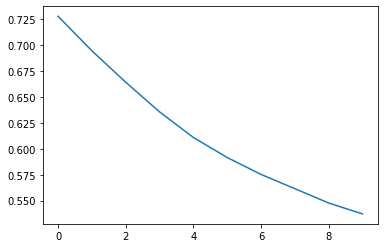

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

# Premières expériences (pour aller plus loin en datascience)

- Commencez par 2 000 exemples, puis utilisez toutes les données d'entraînement (réparties équitablement entre exemples positifs et négatifs).

- Créez un ensemble de développement et un ensemble de test.

- Testez différentes paramétrisations du modèle (ici, la taille de l'embedding) et l'hyperparamètre (le taux d'apprentissage) pour chaque configuration.

- Comparez ces différentes configurations (fonction de perte sur l'ensemble d'entraînement et précision de la classification).

# Un modèle plus profond

On peut ajouter une couche cachée au classificateur précédent.

- Procéder de la même manière qu'auparavant avec les différentes configurations.

- Trouver les hyperparamètres optimaux.